# Checkpoint 3: Convolutional neural networks and autoencoders
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)



In this checkpoint exercise we will use the Quick Draw dataset. 

The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The bitmap dataset contains these drawings converted from vector format into 28x28 grayscale images.

We will focus on a subset of 10 classes of type "body part"

The class labels are:

![listbodypart](./list_body_parts.png)

| <p align='left'> Label                   | <p align='left'> Description| 
| ---------------------------------------- | --------------------------- |
| <p align='left'> 0                       | <p align='left'> arm        |
| <p align='left'> 1                       | <p align='left'> ear        | 
| <p align='left'> 2                       | <p align='left'> eye        |  
| <p align='left'> 3                       | <p align='left'> face      | 
| <p align='left'> 4                       | <p align='left'> foot       | 
| <p align='left'> 5                       | <p align='left'> hand       | 
| <p align='left'> 6                       | <p align='left'> knee       |
| <p align='left'> 7                       | <p align='left'> leg        |
| <p align='left'> 8                       | <p align='left'> mouth      |
| <p align='left'> 9                       | <p align='left'> nose     |


Players draw items as quickly as possible, and as you can see, some images are quite bad! We will try and train a CNN classifier to anyway see if we can train a model to distinguish the classes. We will then train an autoencoder to learn a laten space representations of the dataset.

    
This week, like last, I am not providing example notebooks like `lecture2.ipynb` and `data-science-tools.ipynb` for Unit 2, though these may still be useful to you. Instead, I am **providing the imports for all of the modules and classes that you should need.** 

### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 22 October 2021** 
- This CP exercise sheet is divided into **5 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title          | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ---------------------------------------- | --------------------- | -------------------- |
| <p align='left'> 1. Visualisation and Abstraction   | <p align='left'>   1  | <p align='left'> 1.5 |
| <p align='left'> 2. Image classification | <p align='left'> 2–5  | <p align='left'> 3.5 | 
| <p align='left'> 3. Auto-encoders        | <p align='left'> 6–9  | <p align='left'> 3.0 |
| <p align='left'> 4. Anomaly detection    | <p align='left'> 10–11| <p align='left'> 2.0 |
| <p align='left'> **Total**               |                       | <p align='left'> **10** |

---
You can find the dataset for download at [this link](https://cernbox.cern.ch/index.php/s/obvLeyMR0JEEa5p).
---
---

## Preamble
---

In [1]:
# Standard import(s)
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


In [2]:
# Keras import(s)
if float(tf.__version__[:3])>2.8:
    from tensorflow.keras.utils import plot_model
else:
    from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import regularizers

from tensorflow.python.keras.backend import set_image_data_format
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

## Data preprocessing (given, not marked)
---

First, we'll load in the preprocessed dataset from a numpy data file, which has already been split into training and testing parts for us.



* Each image has been **Reshaped to** $(N,N,1)$ dimension, i.e. image has one color dimention
* Images have been **Scaled** to have pixel intensities in the range [0,1]. It is an important step before feeding them to the neural network model, by dividing the values by 255. It's important that the training set and the testing set be preprocessed in the same way.
* Dataset was **Shuffled** for both training and testing datasets separately.
* Check the shapes of the resulting arrays; make sure they look as you expect.

In [3]:
#Load quickdraw bodyparts dataset
X_train, y_train, X_test, y_test = np.load('quickdraw_bodyparts.npy',allow_pickle=True) 


In [4]:
#Image labels
body_parts = ['arm', 'ear', 'eye', 'face','foot', 'hand', 'knee', 'leg', 'mouth','nose']

In [5]:
# Each label of the dataset correspond to a class name
class_names = body_parts

nb_train   = X_train.shape[0]
nb_test    = X_test.shape[0]
nb_classes = y_train.max() + 1
print("Number of training examples: {}".format(nb_train))
print("Number of testing  examples: {}".format(nb_test))
print("Number of target classes:    {}".format(nb_classes))

# Get image shape
shape = X_train.shape[1:]
print("Image shape:  {}".format(shape))

Number of training examples: 160000
Number of testing  examples: 40000
Number of target classes:    10.0
Image shape:  (28, 28, 1)


## Image visualisation and abstraction (1.5 marks)

#### 1. Display images of the training dataset, and check that the associated label makes sense (0.5 mark)

You will use `matplotlib.pyplot`, the `plt.imshow` method. Use the `cmap=plt.cm.binary` color map for all subsequent img plots.

1. plot 10 training dataset images, one per category. Label the images.

Text(0.5, 1.0, 'Knee')

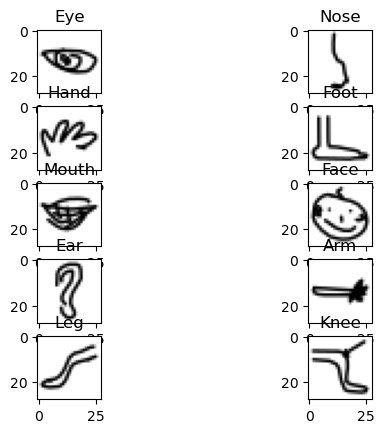

In [6]:
#Created dictionary containing target images and their correspong numbers.
dic = {
    0.0 : "Arm",
    1.0 : "Ear",
    2.0 : "Eye",
    3.0 : "Face",
    4.0 : "Foot",
    5.0 : "Hand",
    6.0 : "Knee",
    7.0 : "Leg",
    8.0 : "Mouth",
    9.0 : "Nose",
}


plt.subplot(5,2,1)
plt.imshow(X_train[0],cmap=plt.cm.binary)
plt.title(dic[y_train[0]])
plt.subplot(5,2,2)
plt.imshow(X_train[1],cmap=plt.cm.binary)
plt.title(dic[y_train[1]])
plt.subplot(5,2,3)
plt.imshow(X_train[3],cmap=plt.cm.binary)
plt.title(dic[y_train[3]])
plt.subplot(5,2,4)
plt.imshow(X_train[5],cmap=plt.cm.binary)
plt.title(dic[y_train[5]])
plt.subplot(5,2,5)
plt.imshow(X_train[8],cmap=plt.cm.binary)
plt.title(dic[y_train[8]])
plt.subplot(5,2,6)
plt.imshow(X_train[11],cmap=plt.cm.binary)
plt.title(dic[y_train[11]])
plt.subplot(5,2,7)
plt.imshow(X_train[17],cmap=plt.cm.binary)
plt.title(dic[y_train[17]])
plt.subplot(5,2,8)
plt.imshow(X_train[20],cmap=plt.cm.binary)
plt.title(dic[y_train[20]])
plt.subplot(5,2,9)
plt.imshow(X_train[25],cmap=plt.cm.binary)
plt.title(dic[y_train[25]])
plt.subplot(5,2,10)
plt.imshow(X_train[34],cmap=plt.cm.binary)
plt.title(dic[y_train[34]])



# 2. plot the fist 25 images in a 5x5 plot. Label the images.

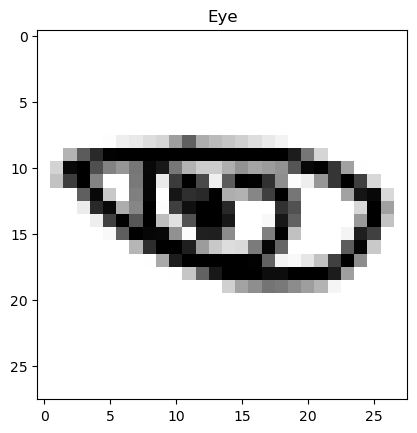

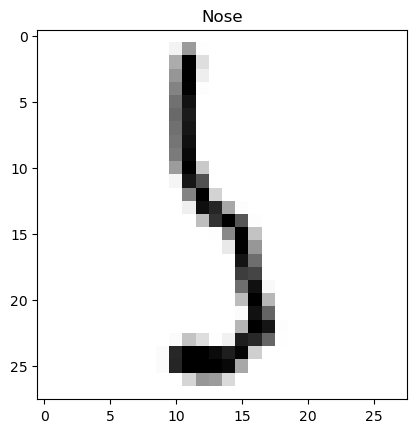

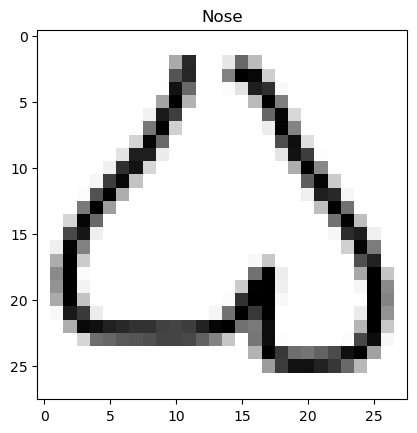

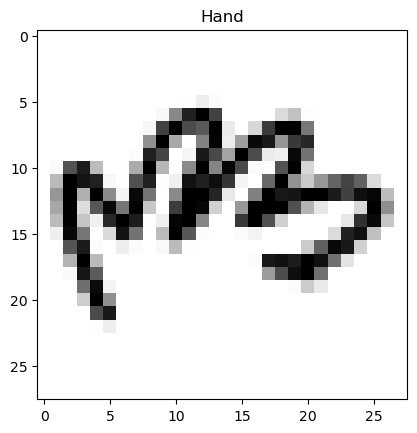

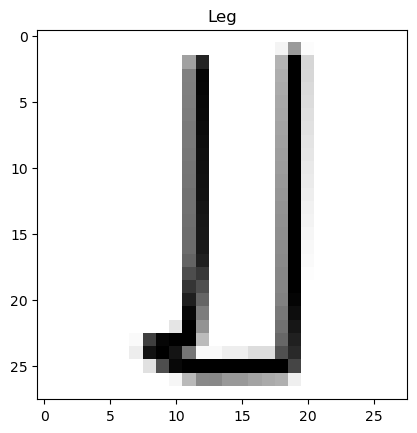

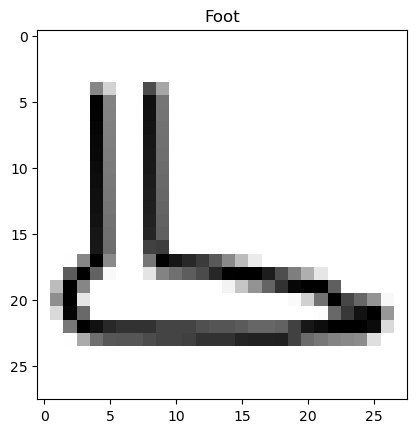

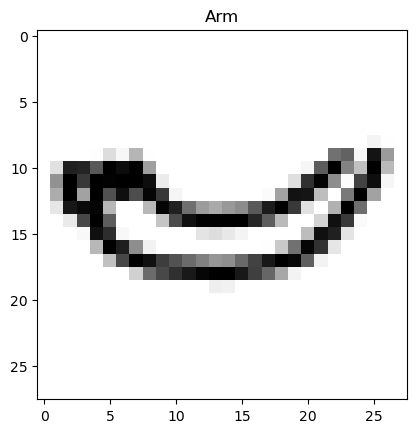

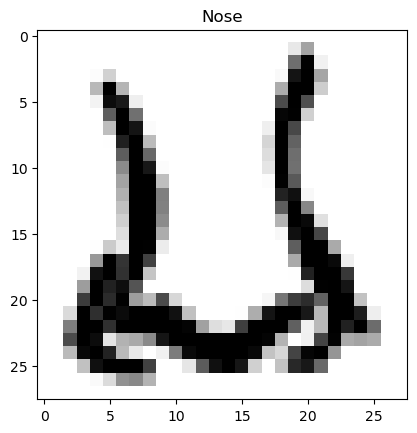

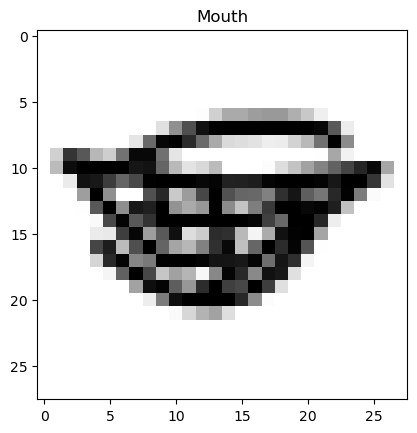

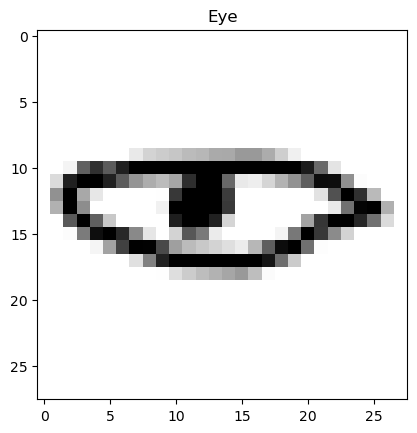

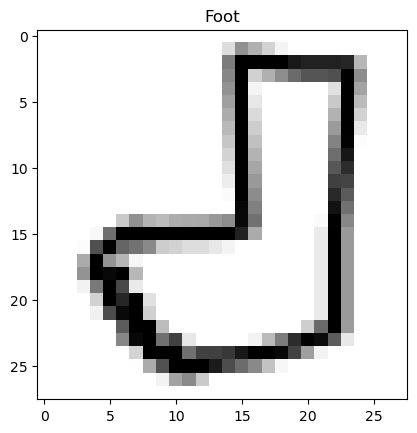

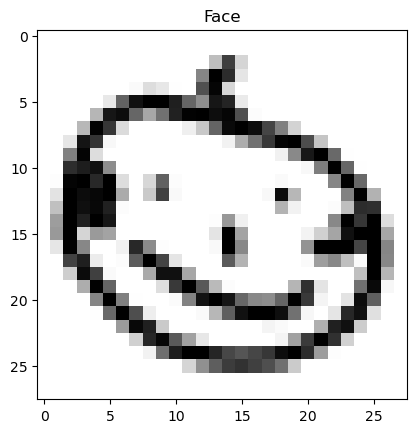

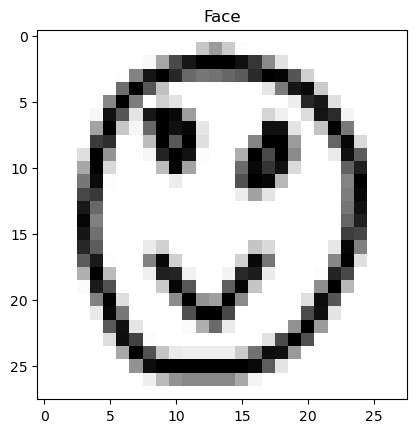

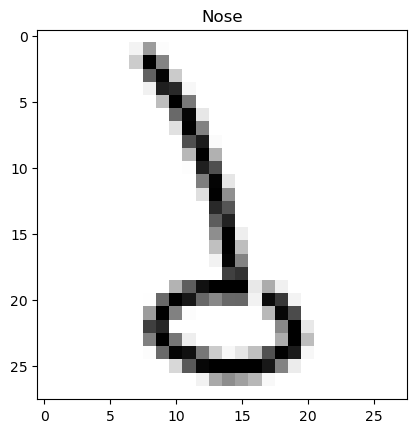

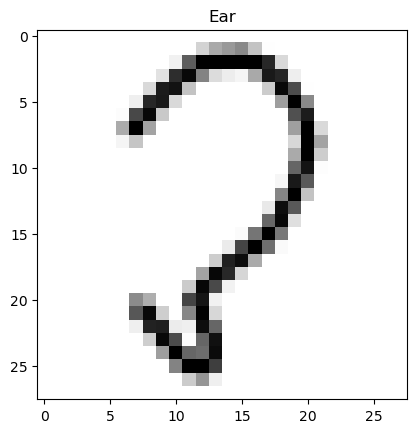

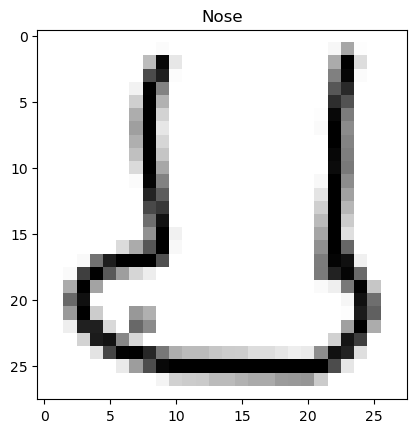

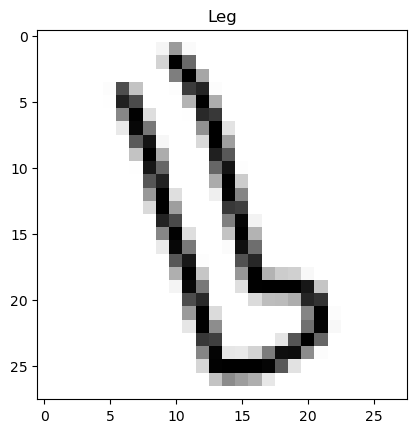

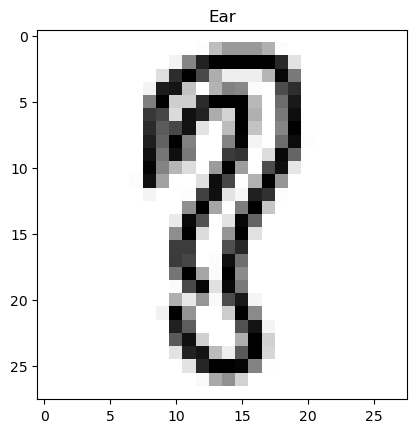

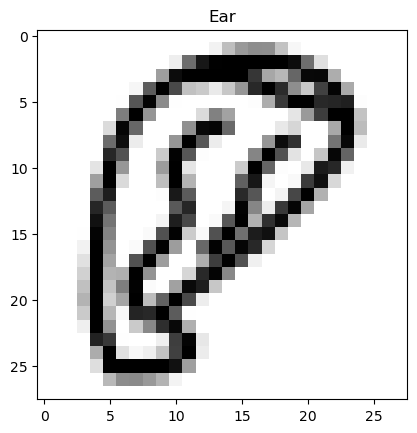

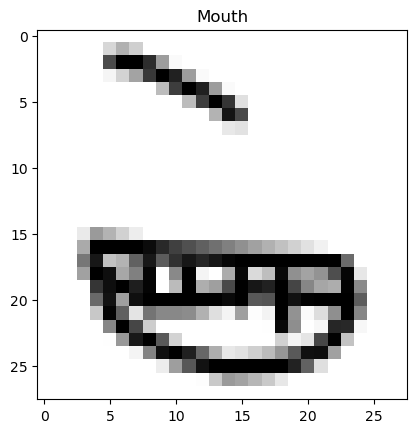

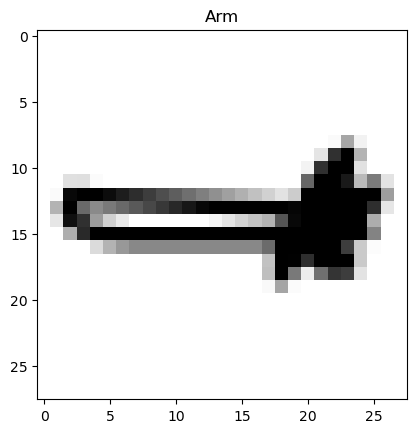

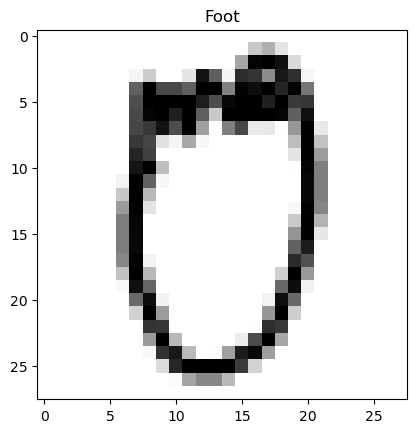

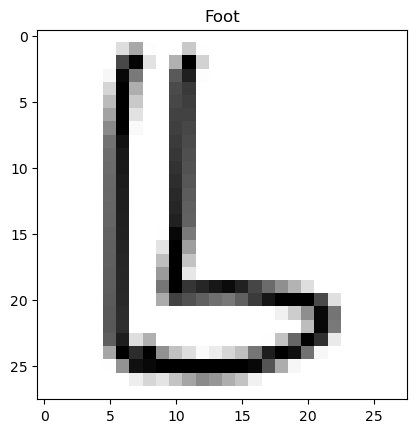

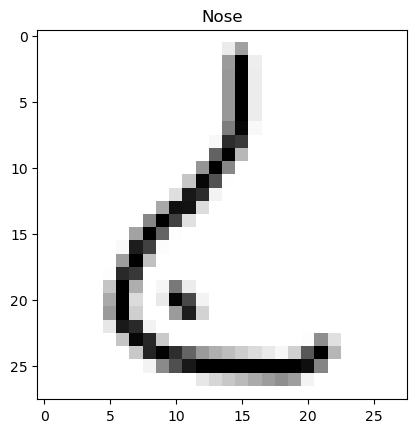

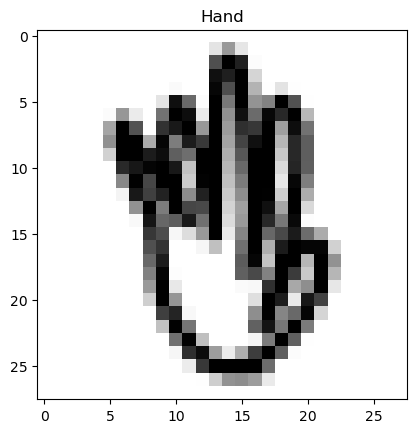

In [7]:
N = 25

fig = plt.figure()

#loop through first 25 images and display with 28x28 image
for i in range(N):  
    plt.imshow(X_train[i],cmap=plt.cm.binary)
    plt.title(dic[y_train[i]])
    plt.show()

#### 2 Apply different kernels to an image of type face (1 mark)

1. pick an image of the face type and save it to `myface`. Plot it with `imshow` (nothing fancy needed for the plot)

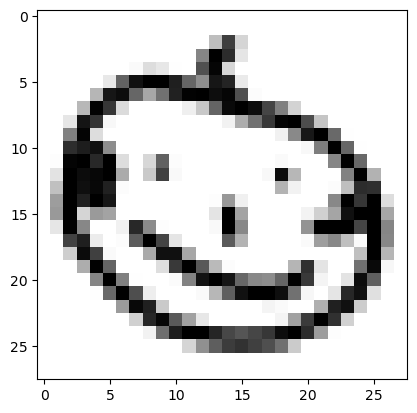

In [8]:
myface = X_train[11]
plt.imshow(myface,cmap=plt.cm.binary)

2. Define 4 kernels: identity, edge_detection, sharpening, and blurring, as `3x3` numpy arrays. We add them to a dictionary of kernels.

In [9]:
#Create 3x3 matrix kernels
k_identity = np.zeros((3,3))        
k_identity[1,1] = 1                  #identity kernel has a one in the centre of the matrix and is surrounded by zeros                    

k_edge= -1*np.ones((3,3))
k_edge[1,1] = 8                      #edge kernel contains 8 in the centre of the matrix and surrounded by -1's
k_sharp= -1*np.ones((3,3))
k_sharp[1,1],k_sharp[0,0],k_sharp[0,2],k_sharp[2,0],k_sharp[2,2]= 5,0,0,0,0       #creates sharp kernel matrix with 5 in centre
k_blur = np.ones((3,3))/9                                                         #creates blur 

kernels = {"identity":k_identity,"edge":k_edge,"sharp":k_sharp,"blur":k_blur}     #kernel dictionary


3. Given is part of the `run_kernel` function which runs over the figure and applies the kernel to every non-edge pixel. Complete the function:
    - Define the shape of the output image `np.empty(...)`
    - Define the ranges of the row and colum loops , i.e. `range(...)`
    - Define the fig index on which the kernel is multiplied in each step, ie. `fig[....]`



In [10]:
def run_kernel(fig,kernel):
    #empty array holding the output image. Define the output dimensions as excercise.
    
    out = np.empty((26,26,1))                        #26x26 array since lose 2 rows and 2 columns when we apply kernel
    #nested loop to iterate through each element of empty out array. In each iteration of j set the matrix element to the value
    #calculated
    for i in range(0,26):                           
        for j in range(0,26):
            out[i][j] = np.sum(np.multiply(kernel,fig[i:3+i,j:3+j]))     #sum of elementwise multiplication of kernel and 3x3 pixels of fig
                
    return out


In [12]:
#This was used to figure out function above
print(myface[:3,:3])
#testarryd = np.array([[1, 2,1], [3, 4,1], [3, 4,1]])
print(np.sum(np.multiply(kernels["edge"],myface[:3,:3])))
#plt.imshow(run_kernel(myface,kernels["edge"]), cmap=plt.cm.binary,norm=norm(0,1)) 

[[[0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]]]
0.0


4. run the plotting code block below and check that the kernels are doing what you expect.
    
Since some kernels multiply by negatives, we use the norm=norm(0,1) to scale the image back to between 0 and 1 before plotting. 

In [12]:
#Import the normiliser for the bitmap
from matplotlib.colors import Normalize as norm

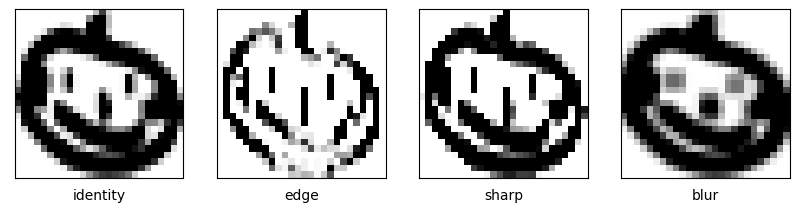

In [13]:
plt.figure(figsize=(10,10))
#Loop over kernel
for i,kernel in enumerate(kernels):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #return transformed image and plot it
    plt.imshow(run_kernel(myface,kernels[kernel]), cmap=plt.cm.binary,norm=norm(0,1))  
    plt.xlabel(kernel)
plt.show()

#Images make sense, identitity returns cropped version of image. Sharp image looks more vivid and blur image looks blurier. 
#edge image shows that the edge kernel displays the ridges of an image more clearly.


## Image classification (3.5 mark)
---
In this section, we will train a convolutional neural network (CNN) to perform hand-written digit recognition; a standard form of image classification. We will:
- create the model
- train the model
- evaluate its classification performance

#### 3. Define a Convolutional Neural Network suitable for image classification (1 mark).

* Use the **`Keras` functional API** to construct the model. 
* The shape of the input layer should match the shape of the prepared images.
* Add some **convolutional** and **pooling** layers in a sensible configuration. The architecture is a bit up to you, but try to reach a good level of accuracy. Around 85% on validation seems easily achievable.
    * By default, you can use $3 \times 3$ kernels, ReLU activation, and $2\times 2$ pooling; but feel free to play around with different values.
    * By default no padding is applied. You could try "same" padding in order to use the whole image, though results don't change much for me.
    * If sufferening from large overtraining could try regularisation: `kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)`
   
* **Flatten** the output of the last convolutional layer.
* Connect it, to an **output** layer with the appropriate number of nodes and choice of activation function.
* Display the model architecture using the `<model>.summary()` method. Optionally display it also with the `plot_model(<model>, show_shapes=True)` method.  
* Questions:
    * _What are the number of trainable parameters in the model?_
    * _How many trainable parameters does your first convolutional layer have? Why?_
    * _Which layer has the most trainable parameters?_

In [15]:
inputs = Input(shape=(28,28,1))                                                     #input layer shape matches image shape (28,28,1)
conv1 = Conv2D(24,kernel_size = (3,3),padding="same",activation = 'relu')(inputs)   #first convolutional layer
pool1 = MaxPooling2D(pool_size =(2,2))(conv1)                                       #pooling layer
conv2 = Conv2D(20,kernel_size = (3,3),padding="same",activation = 'relu')(pool1)    #second convolutional layer

flat = Flatten()(conv2)  

#kernel regularizers reduce overfitting
hidden_layer = Dense(12,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu')(flat)

#Used softmax activation since this is multi-class classification with more than 2 class labels
output = Dense(10,activation = 'softmax')(hidden_layer)                             #output layer 10 nodes to match target images

model = Model(inputs=inputs, outputs=output)
model.summary()
plot_model(model,show_shapes = True)

"""
1. 51,762 trainable parameters

2. 240 trainable parameters in the first convolutional layer. This is calculated by summing the 24 x 9 weights 
    and 24*1 biases which gives 240 trainable parameters ie 216 + 24 = 240. 

3.  My hidden layer has the most with 47052 trainable parameters.


"""
    


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 24)        240       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 20)        4340      
_________________________________________________________________
flatten_2 (Flatten)          (None, 3920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                47052     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                130 

'\n1. 51,762 trainable parameters\n\n2. 240 trainable parameters in the first convolutional layer. This is calculated by summing the 24 x 9 weights \n    and 24*1 biases which gives 240 trainable parameters ie 216 + 24 = 240. \n\n3.  My hidden layer has the most with 47052 trainable parameters.\n\n\n'

#### 4. Compile and train the CNN image classifier (1 mark)

* Choose the appropriate loss functiton. 
* Fit for a reasonable number of epochs, use 20% of data for validation. 
* Plot the loss curve(s) by using `matplotlib.pyplot` directly with the information in the `<model>.history.history` dict.
* If you run on CPUs, stretch your legs while you wait for the 20 epoches to complete. Now is a good time for a coffee/loo break!

In [16]:
#Used sparse_categorical_crossentropy loss function since this is s classification with more than 2 target labels
#target labels are not hot encoded, they are integers 0-9 so we use sparse_categorical_crossentropy rather than categorical_crossentropy.
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics =['accuracy'])

#fit model with 20 epochs, shuffle each time and 20% of data used for validation.
history= model.fit(X_train,y_train,batch_size =32,epochs = 20,shuffle = True,validation_split = 0.2)


Epoch 1/20
4000/4000 [==============================] - 44s 10ms/step - loss: 0.7575 - accuracy: 0.7690 - val_loss: 0.6323 - val_accuracy: 0.8035
Epoch 2/20
4000/4000 [==============================] - 44s 11ms/step - loss: 0.5678 - accuracy: 0.8286 - val_loss: 0.5635 - val_accuracy: 0.8303
Epoch 3/20
4000/4000 [==============================] - 46s 12ms/step - loss: 0.5229 - accuracy: 0.8443 - val_loss: 0.5300 - val_accuracy: 0.8407
Epoch 4/20
4000/4000 [==============================] - 39s 10ms/step - loss: 0.4987 - accuracy: 0.8520 - val_loss: 0.5221 - val_accuracy: 0.8448
Epoch 5/20
4000/4000 [==============================] - 44s 11ms/step - loss: 0.4836 - accuracy: 0.8574 - val_loss: 0.5195 - val_accuracy: 0.8461
Epoch 6/20
4000/4000 [==============================] - 45s 11ms/step - loss: 0.4707 - accuracy: 0.8616 - val_loss: 0.5139 - val_accuracy: 0.8472
Epoch 7/20
4000/4000 [==============================] - 39s 10ms/step - loss: 0.4617 - accuracy: 0.8646 - val_loss: 0.5248 -

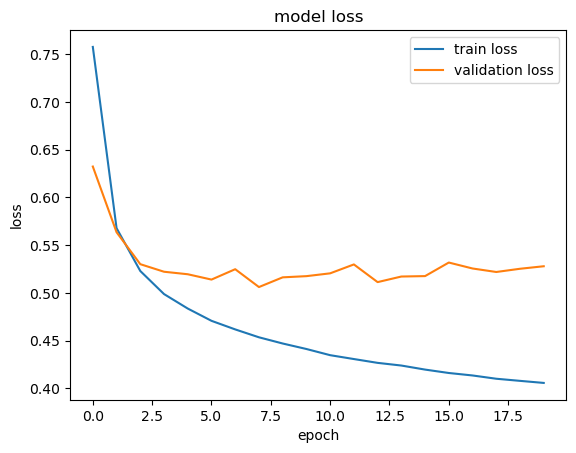

In [18]:

#Plotting loss values from history
fig,ax = plt.subplots()
ax.plot(history.history['loss'], label = "train loss")
ax.plot(history.history['val_loss'],label = "validation loss")
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.set_title('model loss')
ax.legend()

#### 5. Evaluate the classification performance on the testing dataset (1 Mark)

* Compute the testing accuracy, _e.g._ using the `<model>.evaluate()` method. Compare to the training accuracy; can be read off from fit printout, if you added the `'accuracy'` metric, or can be calculated here.
* Display a few mis-classified images from the test dataset.
    * For this you will need to use the model to predict from the testing features.
    * This yields arrays of 10 probabilities, 1 per class. Get the index from maximum probability to find the class prediction. Maybe consider using `argmax`?
* Compute and display the confusion matrix (normalise by truth label). Discuss the results.

In [19]:
val_loss, val_accuracy =model.evaluate(X_train,y_train)
loss, accuracy = model.evaluate(X_test,y_test)


print("Training loss, training accuracy:",val_loss, val_accuracy )
print("Test loss, test accuracy:",loss, accuracy)

#The testing accuracy is 0.85 which is slightly lower than the training accuracy of 0.89
#This is expected and a good result since it means the data has not been over or underfit.

1250/1250 [==============================] - 5s 4ms/step - loss: 0.5282 - accuracy: 0.8504
Training loss, training accuracy: 0.39775750041007996 0.8891500234603882
Test loss, test accuracy: 0.5281732678413391 0.850350022315979


In [21]:
predicted = model.predict(X_test)   


[0, 4, 12, 45]
These were meant to be: 
Leg
Foot
Nose
Arm
But were mis-classified as: 
Knee
Leg
Arm
Foot


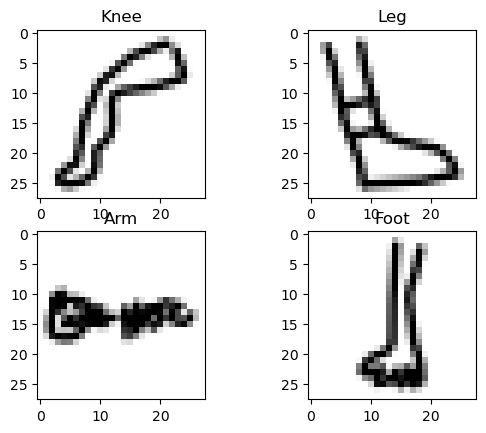

In [36]:
count = 0
i = 0
misclass = []      #stores index i of misclassified images

#This while loop continues to loop through until 4 misclassified images are found
while count < 4:
    #This compares index of highest probability predicted with the actual target image. If they are not the same, the model
    #has misclassified the image.
    if np.argmax(predicted[i])-int(y_test[i]) != 0:
        count += 1
        misclass.append(i)
        plt.subplot(2,2,count)
        plt.imshow(X_test[i],cmap=plt.cm.binary)
        plt.title(dic[np.argmax(predicted[i])])
        
       
    i += 1
    
print(misclass)

print('These were meant to be: ' )
for i in range(4):
    print(dic[y_test[misclass[i]]])
print('But were mis-classified as: ' )
for i in range(4):
    print(dic[np.argmax(predicted[misclass[i]])])


In [38]:
y_pred = np.argmax(predicted,axis = 1)

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'True')]

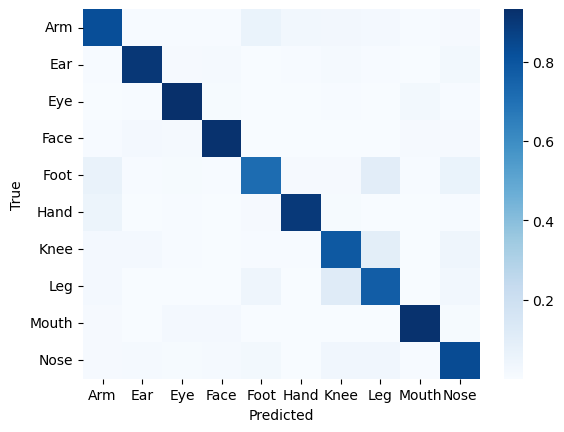

In [40]:

from sklearn.metrics import ConfusionMatrixDisplay
axis_labels = [dic[0.0],dic[1.0],dic[2.0],dic[3.0],dic[4.0],dic[5.0],dic[6.0],dic[7.0],dic[8.0],dic[9.0]]
fig = plt.figure()

conf = confusion_matrix(y_test,y_pred,normalize='true')    #create confusion matrix values

df_cm = pd.DataFrame(conf)
ax = sns.heatmap(df_cm,cmap=plt.cm.Blues,xticklabels = axis_labels, yticklabels = axis_labels )  #plot confusion matrix

ax.set(xlabel='Predicted', ylabel='True')


For your own interest (not marked) run the first layer kernels over `myface`. You should see several copies of the image, all with varying transformations. In your training you may find different kernels, but I can clearly spot a bluring kernel in my first layer.

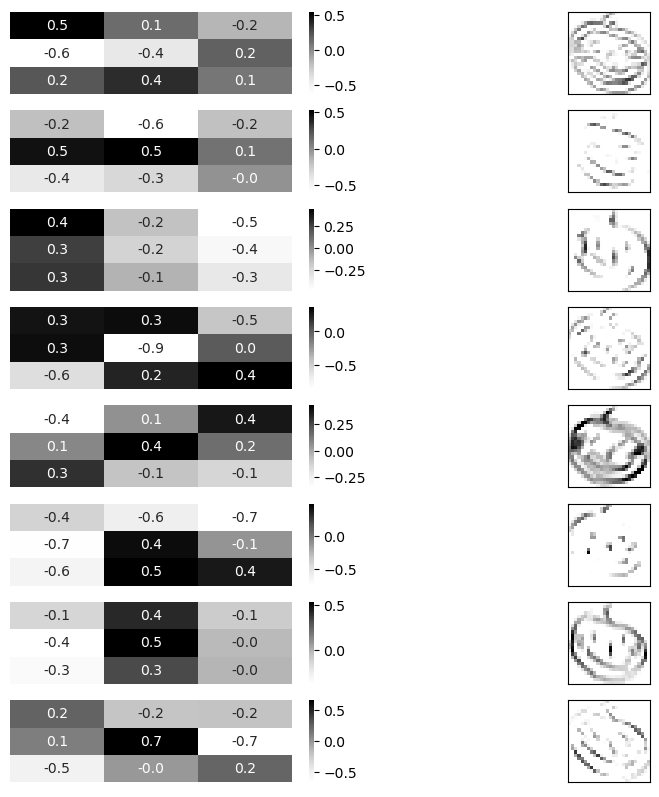

In [41]:
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(8,2,2*(i)+1)

    sns.heatmap(model.layers[1].get_weights()[0][:,:,:,i][:,:,0], cmap='Greys',annot=True,fmt=".1f")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplot(8,2,2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(run_kernel(myface,model.layers[1].get_weights()[0][:,:,:,i]),cmap=plt.cm.binary,norm=norm(0,1))
plt.show()


## Auto-encoders (3 marks)
---
In this section, we will construct and train an auto-encoder as an example of **unsupervised learning.** This type of model is made up of an **encoder** that maps an image of shape $(N,M,C)$ into a latent vector of shape $(L,)$; and a **decoder** which maps the latent vector into an image with the same shape as the original. The latent, or encoded, vector will typically be small in size compared to the input image (_i.e._ $L \ll N \times M \times C$), meaning that it is an **information bottleneck.** The aim of the auto-encoder is therefore to learn the most efficient encoding of a class of images (here: quickdraw dataset) that allows the decoder to reconstruct the original as well as possible under the bottleneck constraint.

We will break down this task into a few sub-tasks, to make it easier to get through.

#### 6. Construct the encoder (1 Marks)

* Use the `Keras` functional API to construct the encoder model. 
* The shape of the input layer should match the shape of the prepared images .
* Add some convolutional and pooling layers in a sensible configuration. 
    * Using a decreasing number of kernels for each convolutional layer (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) works quite well.
    * For this task it is worthwhile to give some thought to padding: You want to have intermediate layers with shapes that are easy to reconstruct with the decoder. As a starting point, consider using `padding='same'` for your conv. layers.
    * **See also the note below.**
* **Flatten** the output of the last convolutional layer, and use this as the latent vector. 
    * For convenience, we choose to make the latent vector have values in the range [0,1], so add the appropriate activation function to the preceeding convolutional layer.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * These methods are also very useful for debugging, when you are building your network. For instance, start with the simplest possible `Keras` model; plot the architecture using one of these methods; modify the model slightly; plot the architecture again to see the effect; _etc._
    * Make sure that the output of the encoder is indeed a bottleneck, _i.e._ that the number of output nodes is significantly smaller than the number of pixels in the image. (_Hint: A latent vector could have size $49 \ll 28 \times 28 \times 1 = 784$._)
    
**Note:** Choosing the architecture for an auto-encoder can be a bit tricky. The input images we use have shape $(28,28,1)$, and when we're pooling we typically downsample by a factor of $2$. If we use "same" padding, this means that we can go down to $(7,7,F)$ with no issues. However, if we downsample further (_e.g._ $7\to 3$) it will be tricky for the decoder to reconstruct, since upsampling would result in $3\to 6$. Therefore, to keep things simple, it may be best to not downsample further than $(7,7,F)$. However, you can still add _multiple convolutional layers in a row without pooling._

In [42]:
input_img = Input(shape=(28,28,1))                                           #Input layer shape (28,28,1)
enc_conv1 = Conv2D(16,(3,3),activation='relu',padding='same')(input_img)     #First convolution layer 16 nodes with padding
enc_pool1 = MaxPooling2D((2,2),padding = 'same')(enc_conv1)                  #2x2 downsampling
enc_conv2 = Conv2D(8,(3,3),activation='relu',padding='same')(enc_pool1)      
enc_pool2 = MaxPooling2D((2,2),padding = 'same')(enc_conv2)                      
enc_conv3 = Conv2D(4,(3,3),activation='relu',padding='same')(enc_pool2)      #No downsample past (7,7,F)
enc_conv4 = Conv2D(2,(3,3),activation='relu',padding='same')(enc_conv3)
enc_conv5 = Conv2D(1,(3,3),activation='sigmoid',padding='same')(enc_conv4)   #Using sigmoid for output between 0 and 1 
flat = Flatten()(enc_conv5)

encoder = Model(inputs = input_img, outputs = flat)
encoder.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 2)           74  

#### 7. Construct the decoder (1 Mark)

* Use the `Keras` functional API to construct the decoder model. 
* **Reshape** the latent vector to have the shape of the last convolutional layer in the encoder.
* The shape of the input layer should match the shape of the latent vector.
* Add some convolutional and **upsampling** layers in a sensible configuration. 
    * You can use the same order of kernels (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) as in the encoder.
    * Many of the notes and considerations mentioned for the encoder hold for the decoder as well.
* The output of the decoder should have the same shape as the number images. Also, choose an output activation that is appropriate to the dataset.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * As for the encoder, these methods can be very useful for debugging.

In [43]:
latent_inputs = Input(49)                                                       #input size matches flattened output of encoder
reshape_layer = Reshape((7,7,1))(latent_inputs)                                 #reshaped input to match last convolutional layer of encoder       
dec_conv2 = Conv2D(16,(3,3),activation = 'relu', padding='same')(reshape_layer) #upsample 3x3 with padding
dec_upsample1 = UpSampling2D((2,2))(dec_conv2)
dec_conv3 = Conv2D(8,(3,3),activation ='relu',padding='same')(dec_upsample1)
dec_upsample2= UpSampling2D((2,2))(dec_conv3)
dec_conv4 = Conv2D(4,(3,3),activation ='relu',padding='same')(dec_upsample2)

dec_conv5 = Conv2D(2,(3,3),activation ='relu',padding='same')(dec_conv4)
dec_conv6 = Conv2D(1,(3,3),activation ='sigmoid',padding='same')(dec_conv5)     #SIngle node output
decoder = Model(inputs =latent_inputs, outputs = dec_conv6)
decoder.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 16)          160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 4)         292 

#### 8. Construct the auto-encoder (given, not marked)

Connecting the encoder and decoder to form the auto-encoder is a slightly tricky use of the `Keras` functional API, so I'll just give that to you. Assuming you have given you encoder and decoder intuitive names, the following should do the trick:

In [44]:
i   = encoder.input
cae = Model(i, decoder(encoder(i)), name='ConvAE')
cae.summary()

Model: "ConvAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_1 (Functional)         (None, 49)                1705      
_________________________________________________________________
model_2 (Functional)         (None, 28, 28, 1)         1705      
Total params: 3,410
Trainable params: 3,410
Non-trainable params: 0
_________________________________________________________________


Try to make sure that you understand what is going on here: In the `Keras` functional API, layers and even entire models work like functions (thus the name). What we're doing above is passing an input image `i` through the encoder (resulting in a latent vector); passing the output of `encoder` as the input to `decoder` (resulting in a reconstructed image); and finally using the output of `decoder` as the output of the auto-encoder.

#### 9. Compile and train the auto-encoder (1 Mark)

* Choose an appropriate loss function.
* Train for ca. 10 epochs with some data held out for validation. Time for another coffee break!
* Plot the loss curve(s).
* Perform the auto-encoding for the testing images (use the `<model>.predict()` method) and display the first couple of _(a)_ original and _(b)_ auto-encoded images to see whether the outputs resembles the original images.

In [45]:
#Binary_crossentropy as we are doing classification with 2 class labels 
cae.compile(loss='binary_crossentropy', optimizer='adam',metrics =['accuracy'])
history_cae = cae.fit(X_train,X_train,batch_size =32,epochs = 3,shuffle = True,validation_split = 0.2) #3 epochs for due to time constraints.


Epoch 1/3
4000/4000 [==============================] - 734s 183ms/step - loss: 0.1958 - accuracy: 0.7720 - val_loss: 0.1692 - val_accuracy: 0.7784
Epoch 2/3
4000/4000 [==============================] - 717s 179ms/step - loss: 0.1653 - accuracy: 0.7791 - val_loss: 0.1622 - val_accuracy: 0.7800
Epoch 3/3
4000/4000 [==============================] - 742s 185ms/step - loss: 0.1608 - accuracy: 0.7801 - val_loss: 0.1595 - val_accuracy: 0.7800


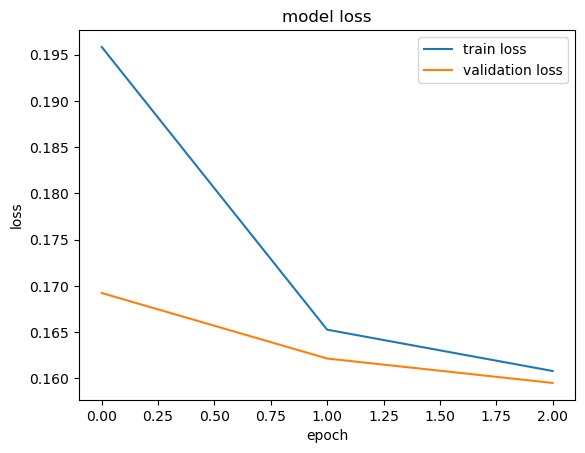

In [46]:

fig,ax = plt.subplots()
ax.plot(history_cae.history['loss'], label = "train loss")
ax.plot(history_cae.history['val_loss'],label = "validation loss")
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.set_title('model loss')
ax.legend()

In [48]:
predict_enc = cae.predict(X_test)

Text(0.5, 1.0, 'Original')

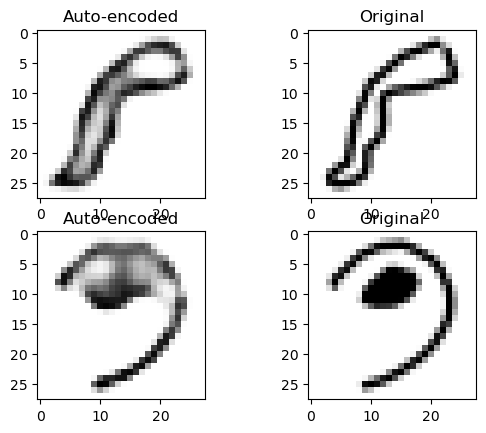

In [49]:

plt.subplot(2,2,1)
plt.imshow(predict_enc[0],cmap=plt.cm.binary)
plt.title('Auto-encoded')
plt.subplot(2,2,2)
plt.imshow(X_test[0],cmap=plt.cm.binary)
plt.title('Original')
plt.subplot(2,2,3)

plt.imshow(predict_enc[1],cmap=plt.cm.binary)
plt.title('Auto-encoded')
plt.subplot(2,2,4)
plt.imshow(X_test[1],cmap=plt.cm.binary)
plt.title('Original')

#### 10. Plot images in the laten space
- Predict 10 images into the laten space using the encoder only.
- Reshape the output to images and plot the laten space images. e.g. if your encoder outputs 49 features, make 7x7 image

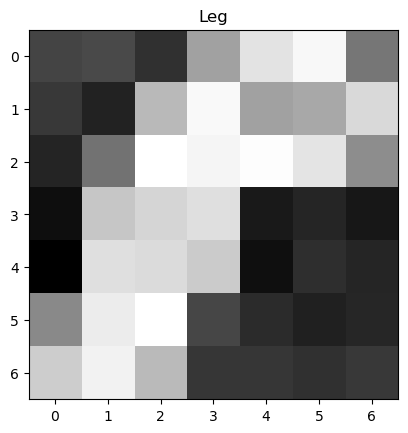

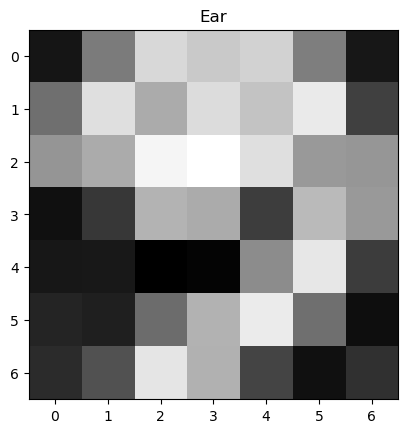

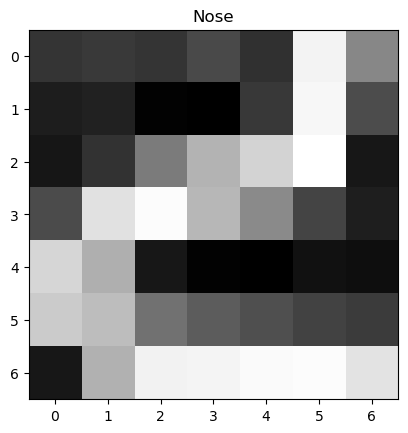

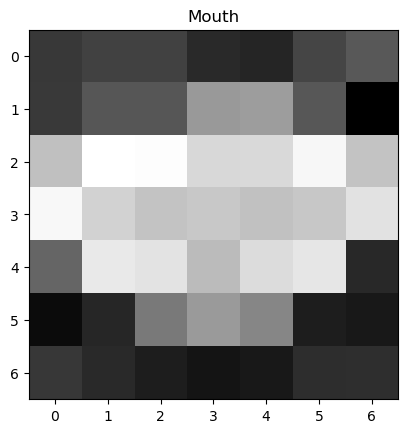

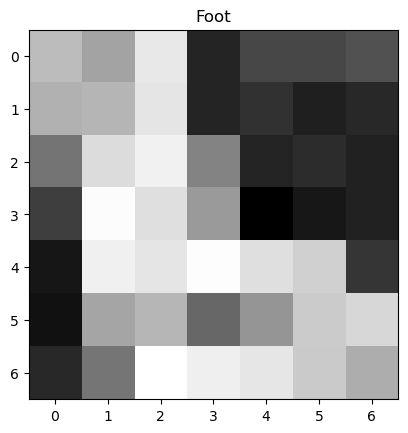

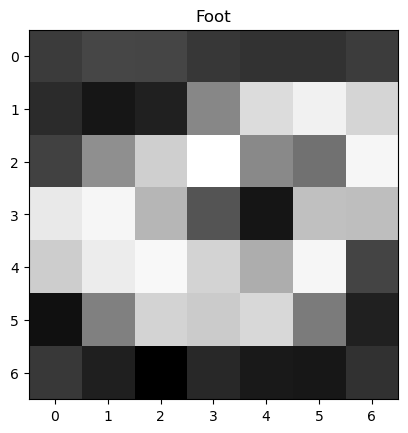

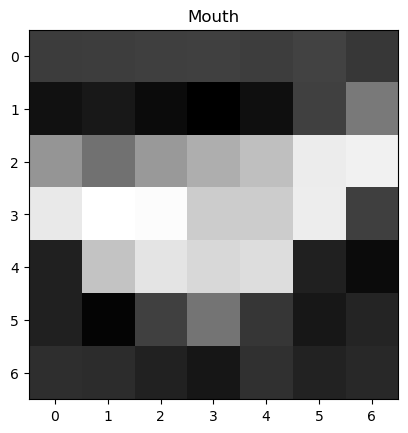

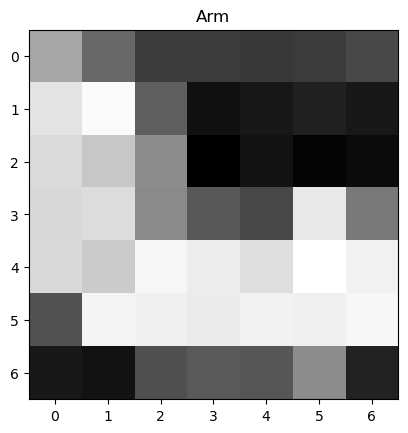

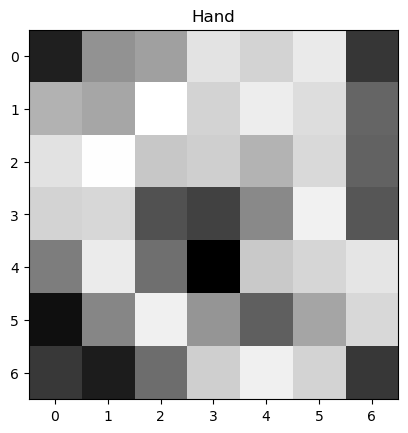

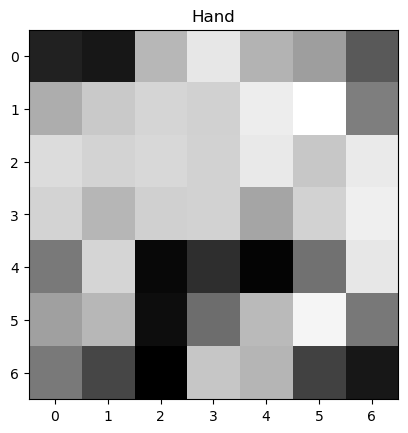

In [50]:
encoder_pred = encoder.predict(X_test)
reshaped = Reshape((7,7,1))(encoder_pred) #reshape output to images
titles = []
for i in range(10):
    titles.append(dic[int(y_test[i])])


for i in range(10):
    
    plt.imshow(reshaped[i],cmap=plt.cm.binary)
    plt.title(titles[i])
    plt.show()

   
    

## Anomaly detection (2 marks)
---

We have introduced auto-encoders as a form of unsupervised learning, since we are not using the image labels during training. This means that auto-encoders are not ideal for image classification (at least not since we actually _have_ the labels), but they can be used for something else: anomaly detection. This is the task of identifying examples that the model considers "anomalous" with respect to the dataset used during training. 

First, we'll load in some "anomalous" data:

In [51]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces(shuffle=True)['images']
faces = faces[:,4:-4:2,4:-4:2,np.newaxis]

#### 9. Inspect the face images and the auto-encoder result (1 mark)

* How many samples does the "outlier" dataset (_i.e._ `faces`) contain?
* What is the shape of the images and what is the range of pixel intensities? Does this conform with the preprocessed quickdraw images?
* Display the first few face images.
* Get the output/prediction of the auto-encoder from the previous section when applied to all of the faces.
* Show the auto-encoded versions of the same faces you showed above. Discuss the results.

In [52]:
print(faces.shape)  #400 samples in outlier dataset
#Images are 28 x 28 pixels and pixel intensities scaled to range [0,1] so they conform with the preprocessed quickdraw images
#This can be seen from shape of faces which is (400,28,28,1) where the 1 corresponds to the pixel intensity range.


(400, 28, 28, 1)


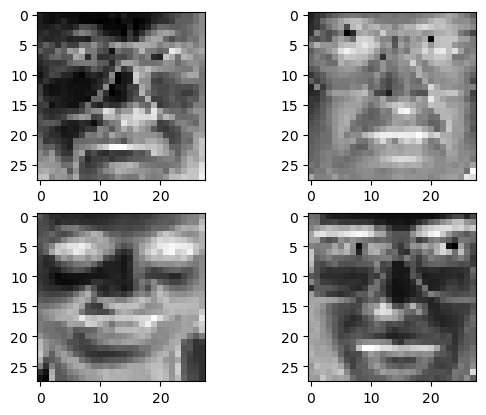

In [54]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(faces[i],cmap=plt.cm.binary)

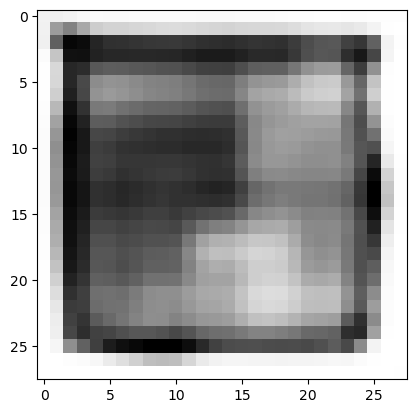

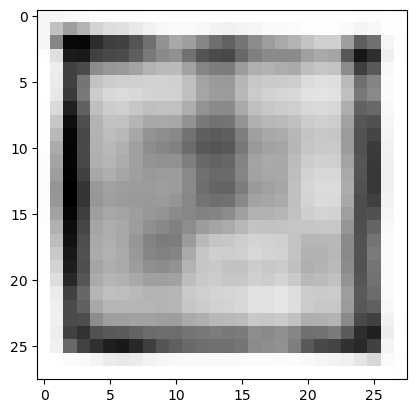

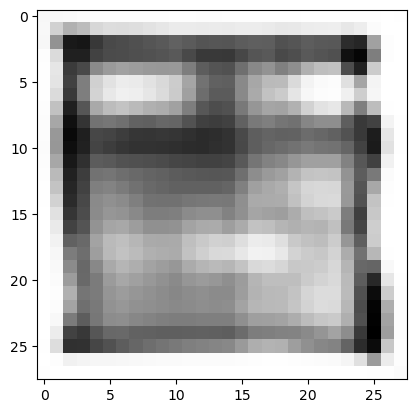

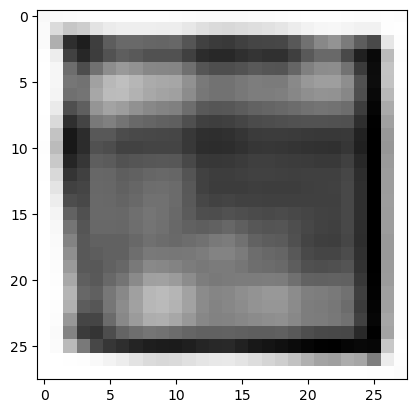

In [56]:
predict_auto = cae.predict(faces)
for i in range(4):
    plt.imshow(predict_auto[i],cmap=plt.cm.binary)
    plt.show()
    
#The auto-encoded faces are much more blurry than the 
#original outlier images.
#It is expected that the auto-encoders do a bad job with 
#these images since they are faces whereas the auto-encoder
#was trained to represent handwritten images.


_Indicative answers:_
    
* The face images have the same shape and pixel intensity range as the preprocessed quickdraw images, so they are valid inputs to the auto-encoder.
* We can see that the auto-encoder transformed faces are _very_ unlike the input images. This is because the auto-encoder was trained to learn an efficient representation of hand-written digits which is not necessarily an efficient representation for other image domains, _e.g._ faces. This examples shows that this is clearly the case. From the point of view of the auto-encoder, images of faces are _anomalies_ in that they are fundamentally unlike the images on which it was trained, and therefore we shouldn't expect it to do a good job in encoding them.

#### 11. Perform anomaly detection (1 mark)
Imagine now that we had a dataset comprised of mostly quickdraw images, but also a small subset of anomalies or "outliers"; here, in the form of black-and-white images of faceses, with the same shape as the quickdraw images.

In [57]:
# Combined MNIST images and "outliers" in a mixed dataset
mixed = np.vstack((X_test, faces))

# Shuffle the mixed dataset so the "outliers" are randomly distributed
indices = np.random.permutation(mixed.shape[0])
mixed   = mixed[indices]

The auto-encoder was trained to minimise the difference between the original and the auto-encoded image, so let's use binary cross-entropy (BCE) as our metric for the difference between an image and its auto-encoded version. The `binary_crossentropy` method provided below computes **pixel-wise BCE** for two (arrays of) images: the input and the output image.

In [58]:
def binary_crossentropy (img_in, img_out):
    assert img_in.shape == img_out.shape
    eps = np.finfo(float).eps
    img_out = np.clip(img_out, eps, 1. - eps)
    return - (img_in * np.log(img_out) + (1 - img_in) * np.log(1 - img_out))

---
* Define a new method called `difference` which takes as input two arrays of images (`img_in` and `img_out`; similar to the `binary_crossentropy`); computes the **average BCE value for each image,** or row; and returns a vector of these difference measures.
* For each image, or row, in `mixed`, compute the difference score of the auto-encoded image wrt. the original image. This is a measure of how "inlier"- or "outlier"-like an image is.
* Make a histogram of these scores, and see if you can identify any structure. It might be useful to use a logarithmic x-axis (see `plt.xscale`) along with logarithmic x-axis bins (see `np.logspace`).
* Show the 9 least and the 9 most outlying images, according to this difference score. Discuss the results.

In [84]:
#function runs binary_crossentropy function above with the mixed array and predictions
#it calculates average BCE value for each row which corresponding to each image.
def difference(img_in, img_out):
    avg = np.mean((binary_crossentropy(img_in, img_out)),axis =(1,2,3))
    return avg

    

In [69]:
avg_BCE = difference(mixed, cae.predict(mixed))

Text(0, 0.5, 'Frequency')

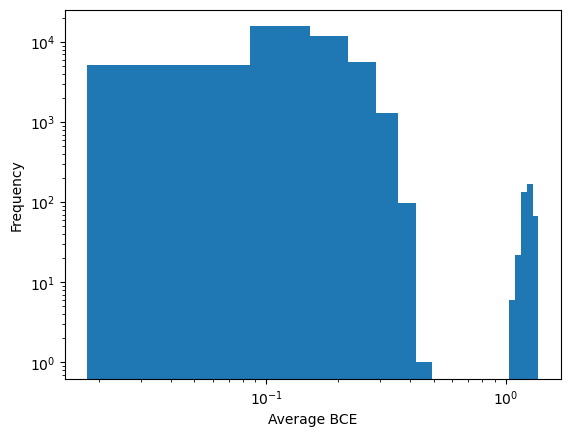

In [79]:
plt.hist(avg_BCE, bins = 20, log = True)
plt.xscale('log')
plt.xlabel('Average BCE')
plt.ylabel('Frequency')

#Note outliers have average BCE >= 1 separated from rest of
#data

In [81]:
print(avg_BCE.shape)

(40400,)


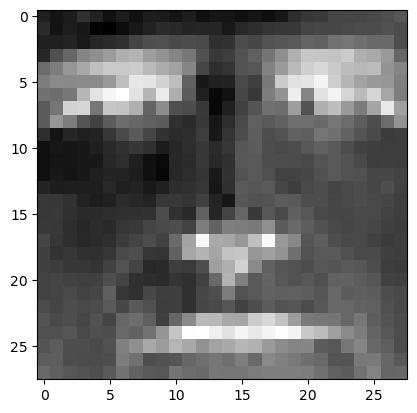

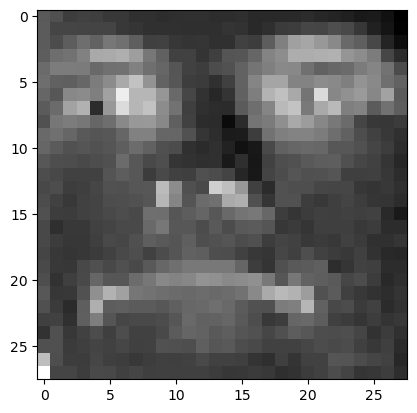

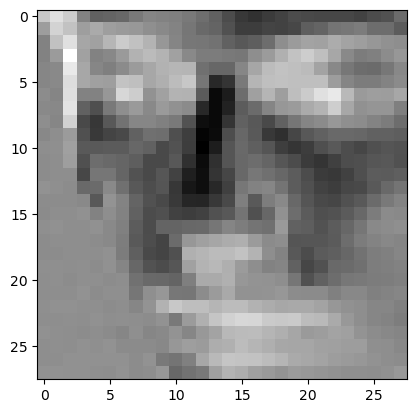

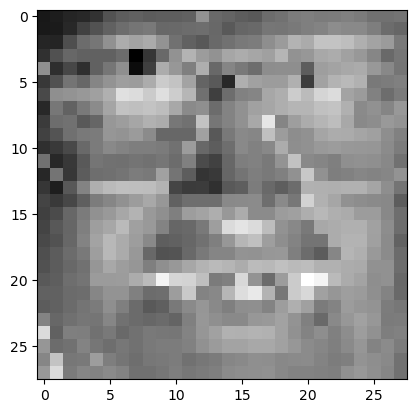

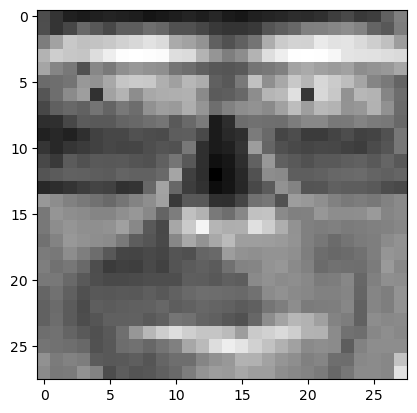

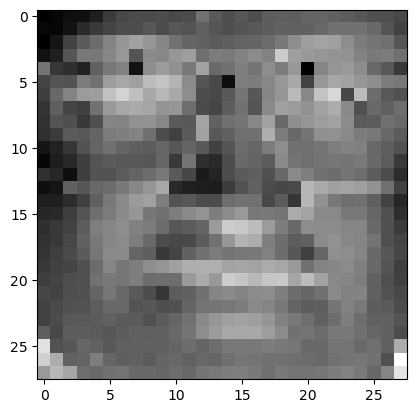

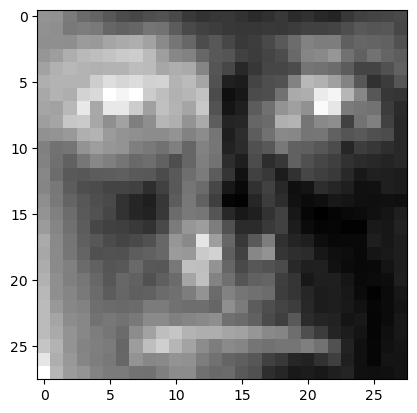

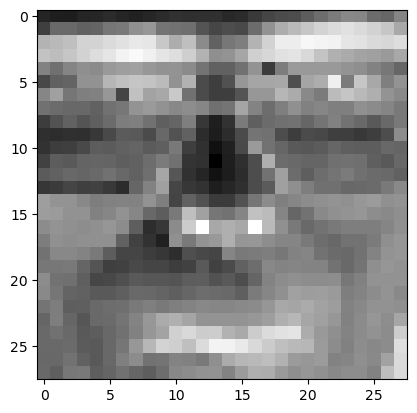

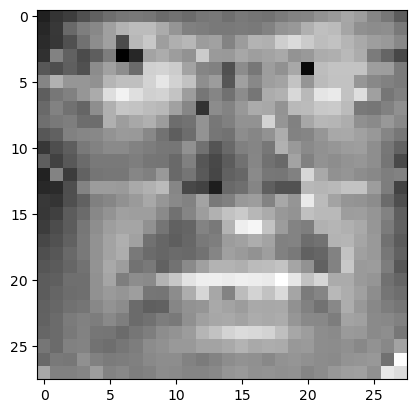

In [111]:
highest = np.argpartition(avg_BCE, -9)[-9:] #these are the 9 highest average BCE ie most outliers.

for i in range(9):
    plt.imshow(mixed[highest[i]],cmap=plt.cm.binary)
    plt.show()
    
#9 most outliers are all faces from outlier dataset as expected since the autoencoders were trained on the handwritten drawings
#rather than these images of faces. Therefore, we expect the original images to be the most different from the autoencoded 
#images for the faces.
#9 least outliers are much simpler images which much more closely represent the data that the autoencoder was trained on. Therefore,
#we expect the original images to look similar to the autoencoded images.

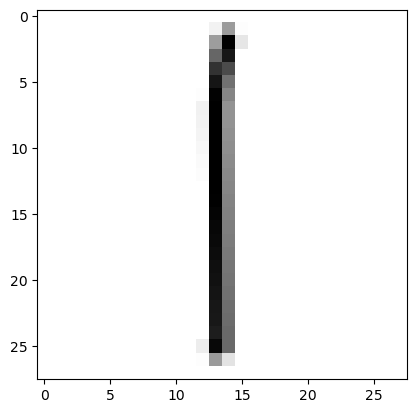

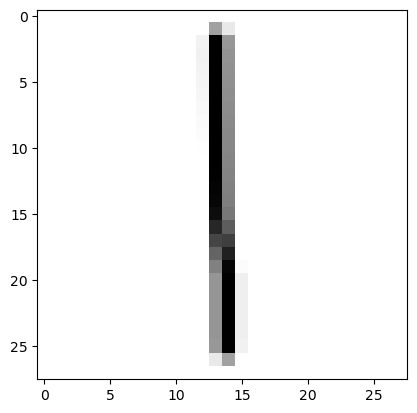

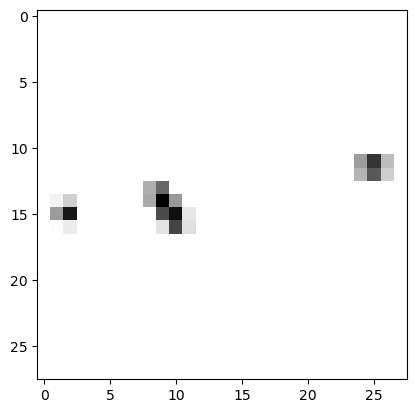

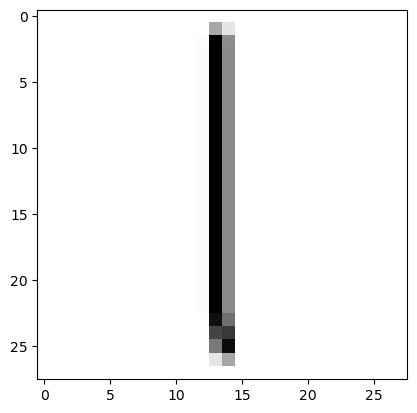

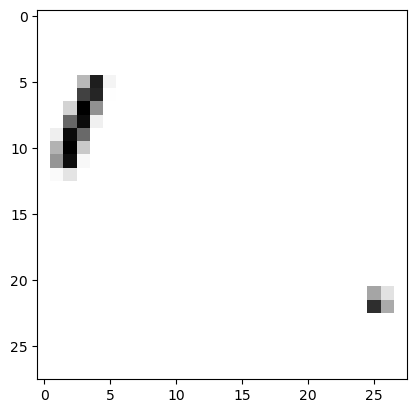

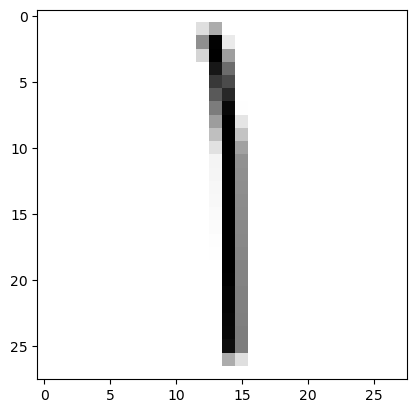

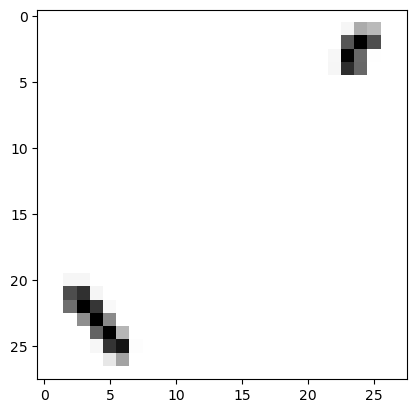

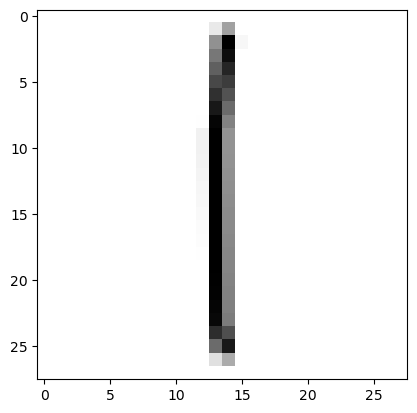

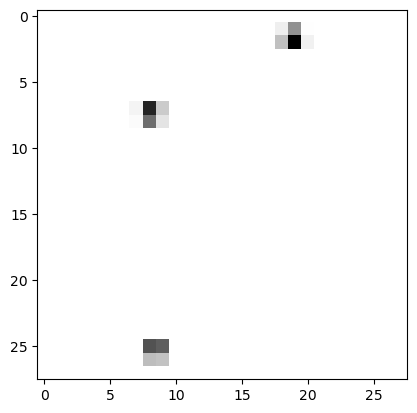

In [112]:
lowest = np.argpartition(avg_BCE, 9)[:9]
for i in range(9):
    plt.imshow(mixed[lowest[i]],cmap=plt.cm.binary)
    plt.show()